In [207]:
#Importing necessary libraries 
import keras
import numpy as np
import pandas as pd
from keras.applications import resnet50
from keras import models
from keras import layers
from keras import optimizers
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from keras.callbacks import ModelCheckpoint

In [208]:
# Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))




In [168]:
# checking the trainable status of the individual layers
for layer in resnet_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f01a62957f0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f01a52a0780> True
<keras.layers.convolutional.Conv2D object at 0x7f01a52c3978> True
<keras.layers.normalization.BatchNormalization object at 0x7f01bc25dc50> True
<keras.layers.core.Activation object at 0x7f01bc25dc18> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f019d223b38> True
<keras.layers.pooling.MaxPooling2D object at 0x7f019d21a908> True
<keras.layers.convolutional.Conv2D object at 0x7f019d20f048> True
<keras.layers.normalization.BatchNormalization object at 0x7f01aa429ba8> True
<keras.layers.core.Activation object at 0x7f01aa429f60> True
<keras.layers.convolutional.Conv2D object at 0x7f01aa4494a8> True
<keras.layers.normalization.BatchNormalization object at 0x7f01aa402d68> True
<keras.layers.core.Activation object at 0x7f01aa39c400> True
<keras.layers.convolutional.Conv2D object at 0x7f01aa33aa58> True
<keras.layers.convolutional.Conv2D obj

In [169]:
# Adding classifier on top of Convolution model
# create model 
model = models.Sequential()

In [170]:
# Add the resnet50 convolutional model
model.add(resnet_model)

# Adding new Layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

In [171]:
# summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                10250     
Total params: 31,987,594
Trainable params: 31,934,474
Non-trainable params: 53,120
_________________________________________________________________


In [172]:
# Fitting the CNN to the images(Image Augmentation, Image Preprocessing)
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( 
        rescale=1./255,
        shear_range=0.2,             
        zoom_range=0.2,              
        horizontal_flip=True)

In [173]:
#Normalizing the test set
test_datagen = ImageDataGenerator(rescale=1./255)

In [206]:
# setting the path to EuroSat Dataset
path = '/home/sachin_sharma/Desktop/eurosat_dataset'
os.chdir(path)

In [197]:
# loading training data(80%)
training_set = train_datagen.flow_from_directory(
        'TrainingSet',
         target_size=(64,64),
         batch_size=32,
         class_mode='categorical')

Found 21000 images belonging to 10 classes.


In [198]:
# loading test data(20%)
# This will create the Test set
test_set = test_datagen.flow_from_directory(
        'TestSet',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical', 
        shuffle=False)

Found 6000 images belonging to 10 classes.


In [177]:
# lets dettermine dataset characteristics
print('Training Data: ',training_set[0][0].shape)
print('Test Data: ',test_set[0][0].shape)

Training Data:  (32, 64, 64, 3)
Test Data:  (32, 64, 64, 3)


In [178]:
# now shape of a single image
print('Shape of single image:', training_set[0][0][0].shape)

Shape of single image: (64, 64, 3)


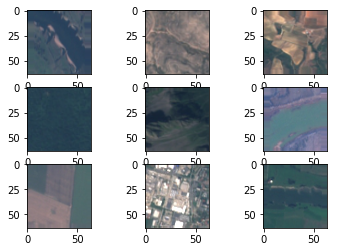

In [179]:
# create a grid of 3*3 images to visualize some of the imgaes in dataset
for i in range(0, 9):
    plt.subplot(330 + 1+ i)
    img = training_set[0][0][i]
    plt.imshow(img)
    
# show the plot
plt.show()

In [180]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [181]:
# checkpoint
filepath="/home/sachin_sharma/Desktop/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [182]:
# Train the model
history = model.fit_generator(
          training_set, 
          steps_per_epoch=(training_set.samples/32),
          epochs=20,
          callbacks=callbacks_list,
          validation_data=test_set,
          validation_steps=(test_set.samples/32))

Epoch 1/20
657/656 [==============================] - 63s 96ms/step - loss: 0.4627 - acc: 0.8741 - val_loss: 0.4953 - val_acc: 0.9172

Epoch 00001: val_acc improved from -inf to 0.91717, saving model to /home/sachin_sharma/Desktop/weights.best.hdf5
Epoch 2/20
657/656 [==============================] - 46s 70ms/step - loss: 0.2324 - acc: 0.9390 - val_loss: 0.3630 - val_acc: 0.9490

Epoch 00002: val_acc improved from 0.91717 to 0.94900, saving model to /home/sachin_sharma/Desktop/weights.best.hdf5
Epoch 3/20
657/656 [==============================] - 45s 69ms/step - loss: 0.2288 - acc: 0.9439 - val_loss: 0.4792 - val_acc: 0.9427

Epoch 00003: val_acc did not improve from 0.94900
Epoch 4/20
657/656 [==============================] - 47s 71ms/step - loss: 0.1925 - acc: 0.9544 - val_loss: 0.3715 - val_acc: 0.9523

Epoch 00004: val_acc improved from 0.94900 to 0.95233, saving model to /home/sachin_sharma/Desktop/weights.best.hdf5
Epoch 5/20
657/656 [==============================] - 46s 71ms

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


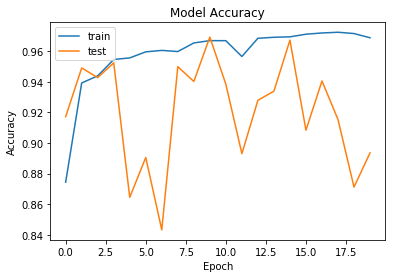

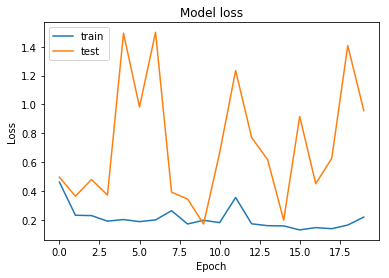

In [205]:
# Plotting the Loss and Classification Accuracy
model.metrics_names
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [200]:
# loading the weights with ~97% acc
from keras.models import load_model
model = load_model('/home/sachin_sharma/Desktop/weights.best.hdf5')

In [204]:
# Visualizing the mapping of labels
test_set.class_indices

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [202]:
# Confusion Matrix and Classification report
# creating 
Y_pred = model.predict_generator(test_set, test_set.samples//32 +1 )
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_set.classes, y_pred)
#print(cm)

def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

df = cm2df(cm, ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", "PermanentCrop", "Residential" ,"River", "SeaLake"])
print(df)

Confusion Matrix
                      AnnualCrop  Forest  HerbaceousVegetation  Highway  \
AnnualCrop                   567       1                     0        0   
Forest                         0     597                     0        0   
HerbaceousVegetation           0       2                   570        0   
Highway                        3       0                     0      578   
Industrial                     0       0                     0        1   
Pasture                        0       1                    11        1   
PermanentCrop                  5       0                    16        3   
Residential                    0       0                     0        0   
River                          4       0                     1        6   
SeaLake                        1       1                     0        0   

                      Industrial  Pasture  PermanentCrop  Residential  River  \
AnnualCrop                     0        6             17            0      3 

In [203]:
print('Classification Report')
target_names = ['AnnualCrop','Forest', 'HerbaceousVegetation', 'Highway',"Industrial", 'Pasture', 'PermanentCrop','Residential', 'River', 'SeaLake']
classifcn_report = classification_report(test_set.classes, y_pred, target_names=target_names)
print(classifcn_report)

Classification Report
                      precision    recall  f1-score   support

          AnnualCrop       0.98      0.94      0.96       600
              Forest       0.99      0.99      0.99       600
HerbaceousVegetation       0.95      0.95      0.95       600
             Highway       0.98      0.96      0.97       600
          Industrial       0.99      0.96      0.98       600
             Pasture       0.97      0.96      0.96       600
       PermanentCrop       0.92      0.95      0.94       600
         Residential       0.96      0.99      0.98       600
               River       0.97      0.97      0.97       600
             SeaLake       0.98      1.00      0.99       600

           micro avg       0.97      0.97      0.97      6000
           macro avg       0.97      0.97      0.97      6000
        weighted avg       0.97      0.97      0.97      6000

